In [1]:
from kubernetes import client, config
import pandas as pd
import matplotlib.pyplot as plt

from prometheus_api_client import PrometheusConnect

from datetime import datetime, timedelta
from difflib import diff_bytes
import matplotlib.pyplot as plt


In [2]:
# test the connecting with Prometheus
# Kubernetes Config
config.load_kube_config()
v1 = client.CoreV1Api()

# Prometheus Config
#prom_url = "http://<PROMETHEUS_SERVER_IP>:<PORT>"
prom_url = "http://10.110.188.57:9090"
prom = PrometheusConnect(url=prom_url, disable_ssl=True)
#test prom connection
response = prom.custom_query(query="up")
print(response)

[{'metric': {'__name__': 'up', 'container': 'alertmanager', 'endpoint': 'http-web', 'instance': '192.168.69.198:9093', 'job': 'prometheus-stack-kube-prom-alertmanager', 'namespace': 'monitoring', 'pod': 'alertmanager-prometheus-stack-kube-prom-alertmanager-0', 'service': 'prometheus-stack-kube-prom-alertmanager'}, 'value': [1709276393.999, '1']}, {'metric': {'__name__': 'up', 'container': 'config-reloader', 'endpoint': 'reloader-web', 'instance': '192.168.5.7:8080', 'job': 'prometheus-stack-kube-prom-prometheus', 'namespace': 'monitoring', 'pod': 'prometheus-prometheus-stack-kube-prom-prometheus-0', 'service': 'prometheus-stack-kube-prom-prometheus'}, 'value': [1709276393.999, '1']}, {'metric': {'__name__': 'up', 'container': 'config-reloader', 'endpoint': 'reloader-web', 'instance': '192.168.69.198:8080', 'job': 'prometheus-stack-kube-prom-alertmanager', 'namespace': 'monitoring', 'pod': 'alertmanager-prometheus-stack-kube-prom-alertmanager-0', 'service': 'prometheus-stack-kube-prom-a

In [7]:

# from prometheus_api_client import PrometheusConnect

# The secled  pod and its namespace
pod_name = "compose-post-service-866f6d7b74-vsd82"
namespace = "social-network"
instance_name = "172.26.128.228:9100"

# Define the time range
end_time = datetime.now()
start_time = end_time - timedelta(days=1)  # Fetching data for the past week
# Construct the query
cpu_usage_pod_query = f'sum(rate(container_cpu_usage_seconds_total{{namespace="{namespace}", pod="{pod_name}"}}[5m]))*100' # For Pod
cpu_usage_node_query = f'100 - (avg by (instance) (irate(node_cpu_seconds_total{{job="node-exporter",mode="idle", instance="{instance_name}"}}[5m])) * 100)' # For Node

#Execute the query
cpu_usage_pod_range = prom.custom_query_range(query=cpu_usage_pod_query, start_time=start_time, end_time=end_time, step='5m')
cpu_usage_node_range = prom.custom_query_range(query=cpu_usage_node_query, start_time=start_time, end_time=end_time, step='5m')


# Define a function to extract time series data
def extract_time_series(metric_data):
    timestamps = [datetime.fromtimestamp(x[0]) for x in metric_data[0]['values']] 
    values = [float(x[1]) for x in metric_data[0]['values']]
    return timestamps, values

# Fetch time series data for CPU usage

# cpu_data = query
# The cpu_data will now contain time series data for the CPU usage rate over the specified time range.
timestamps_pod, cpu_values_pod = extract_time_series(cpu_usage_pod_range)
timestamps_node, cpu_values_node = extract_time_series(cpu_usage_node_range)


# save to CSV file

# Create a DataFrame
df_pod = pd.DataFrame({
    'Timestamp': timestamps_pod,
    'CPU Usage Rate (cores)': cpu_values_pod
})

df_node = pd.DataFrame({
    'Timestamp': timestamps_node,
    'CPU Usage Rate (cores)': cpu_values_node
})

# Save the DataFrame to a CSV file
df_pod.to_csv('/home/ubuntu/ms_scheduling/data/pod_cpu_usage_data.csv', index=False)
df_node.to_csv('/home/ubuntu/ms_scheduling/data/node_cpu_usage_data.csv', index=False)



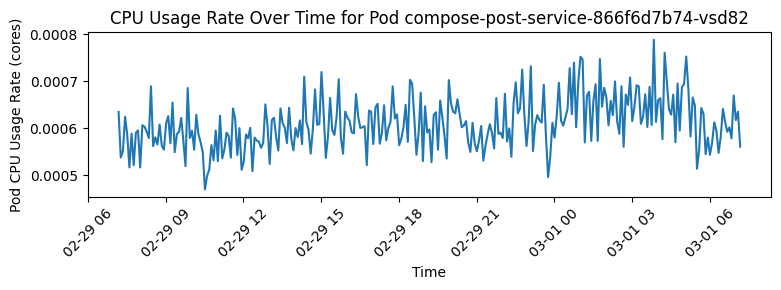

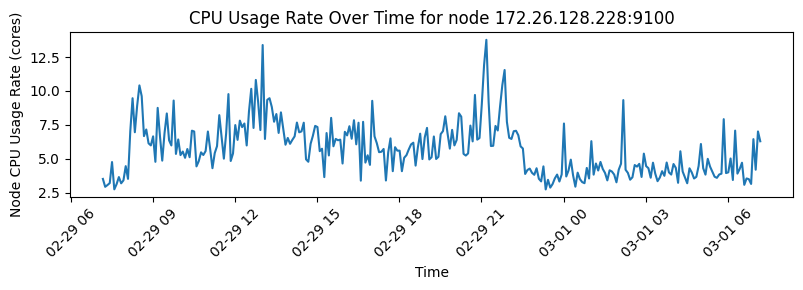

In [8]:

# Plotting Pod CPU usage rate over time
plt.figure(figsize=(8, 3))
plt.plot(timestamps_pod, cpu_values_pod)
plt.xlabel('Time')
plt.ylabel('Pod CPU Usage Rate (cores)')
plt.title(f'CPU Usage Rate Over Time for Pod {pod_name}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plotting Node CPU usage rate over time
plt.figure(figsize=(8, 3))
plt.plot(timestamps_node, cpu_values_node)
plt.xlabel('Time')
plt.ylabel('Node CPU Usage Rate (cores)')
plt.title(f'CPU Usage Rate Over Time for node {instance_name}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

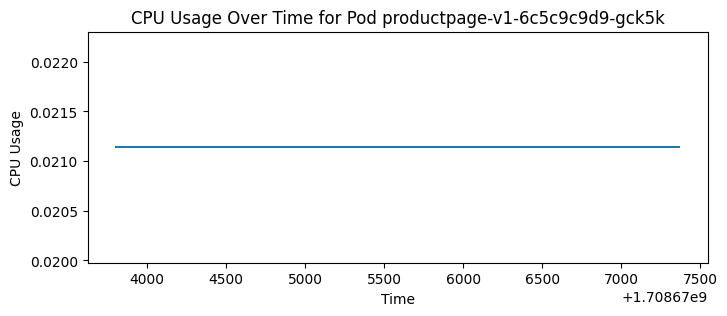

In [10]:
from datetime import datetime, timedelta
# from turtle import st

# Define the time range
end_time = datetime.now()
start_time = end_time - timedelta(hours=24*7)  # Adjust this for the desired range

# Define a function to extract time series data
def extract_time_series(metric_data):
    timestamps = [x[0] for x in metric_data[0]['values']]
    values = [float(x[1]) for x in metric_data[0]['values']]
    return timestamps, values

# Fetch time series data for CPU usage
cpu_query = f'sum(rate(container_cpu_cfs_periods_total{{namespace="{namespace}", pod="{pod_name}"}}[5m]))'
cpu_data = prom.get_metric_range_data(
    metric_name="container_cpu_usage_seconds_total",
    start_time=start_time,
    end_time=end_time,
    chunk_size= timedelta(minutes=60)  # Adjust this for the desired granularity
)

timestamps, cpu_values = extract_time_series(cpu_data)

# Plotting CPU usage over time
plt.figure(figsize=(8, 3))
plt.plot(timestamps, cpu_values)
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.title('CPU Usage Over Time for Pod productpage-v1-6c5c9c9d9-gck5k')
plt.show()

# Repeat the above steps for other metrics like Memory, Network, etc.